In [1]:
import dask
import numpy
import starepandas
import geopandas
import pystare
import pandas
import matplotlib.pyplot as plt
import datetime

In [3]:
us = geopandas.read_file('../tests/data/tl_2017_us_state.gpkg')
us = us.to_crs('EPSG:4326')
len(us)

56

In [4]:
us.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62265662566,489840834,+38.6472854,-080.6183274,"POLYGON ((-81.74725 39.09538, -81.74635 39.096..."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138911437206,31398800291,+28.4574302,-082.4091478,"MULTIPOLYGON (((-82.98748 24.62537, -82.98748 ..."
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143784114293,6211277447,+40.1028754,-089.1526108,"POLYGON ((-91.18529 40.63780, -91.17510 40.643..."
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206229176104,18944967530,+46.3158148,-094.1996628,"POLYGON ((-96.78438 46.63050, -96.78434 46.630..."
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25150696145,6980371026,+38.9466584,-076.6744939,"POLYGON ((-77.45881 39.22027, -77.45866 39.220..."


# Parallel SID lookup

## Manual / low level

In [5]:
n_cores = 55

ddf = dask.dataframe.from_pandas(us.geometry, npartitions=n_cores)
meta = {'stare': 'int64'}

res = ddf.map_partitions(lambda df: numpy.array(starepandas.stare_from_geoseries(df, 7)), meta=meta)
stare = res.compute(scheduler='processes')

## High level

In [6]:
stare = starepandas.stare_from_geoseries(us.geometry, level=7, nonconvex=True, force_ccw=True, n_workers=55)

# Parallel Trixel lookup

## Manual / low level

In [7]:
n_cores = 55

us['stare'] = stare
ddf = dask.dataframe.from_pandas(us['stare'], npartitions=n_cores)
meta = {'trixels': 'object'}

res = ddf.map_partitions(lambda df: numpy.array(starepandas.trixels_from_stareseries(df)), meta=meta)
trixels = res.compute(scheduler='processes')

## High level

In [8]:
stare = pandas.Series(stare)
trixels = starepandas.trixels_from_stareseries(stare, n_workers=55)

# Parallel instantiation

In [9]:
us = starepandas.STAREDataFrame(us, add_stare=True, level=7, add_trixels=True, n_workers=55)

<AxesSubplot:>

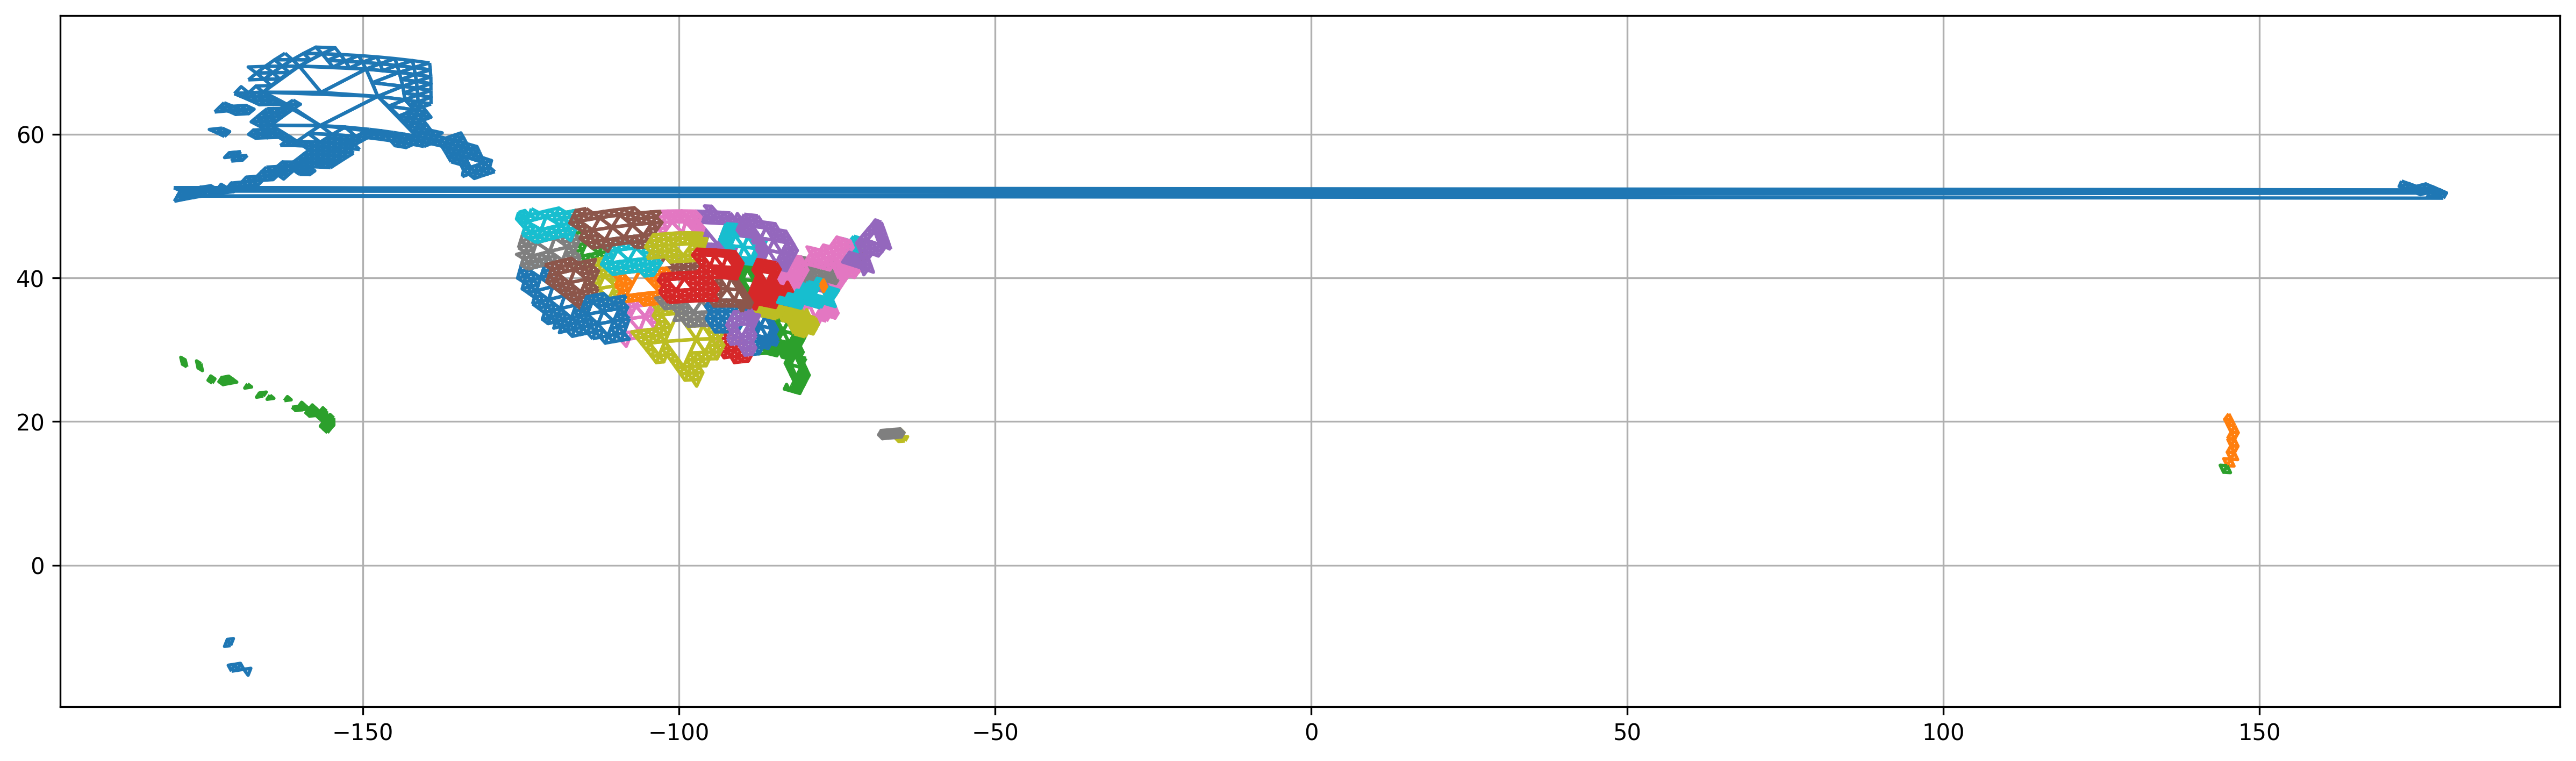

In [10]:
fig, ax = plt.subplots(figsize=(20,20), dpi=300)
ax.grid(True)

us.plot(ax=ax, trixels=True, column='NAME')

# Visualization

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,stare,trixels
31,4,9,15,01779782,15,HI,Hawaii,00,G4000,A,16634117742,11777681513,+22.0120383,-159.7059653,"MULTIPOLYGON (((-166.38653 23.84636, -166.3842...","[1158902847861948423, 1159149138466570247, 115...",(POLYGON ((-165.7746047773546 23.5351684087914...


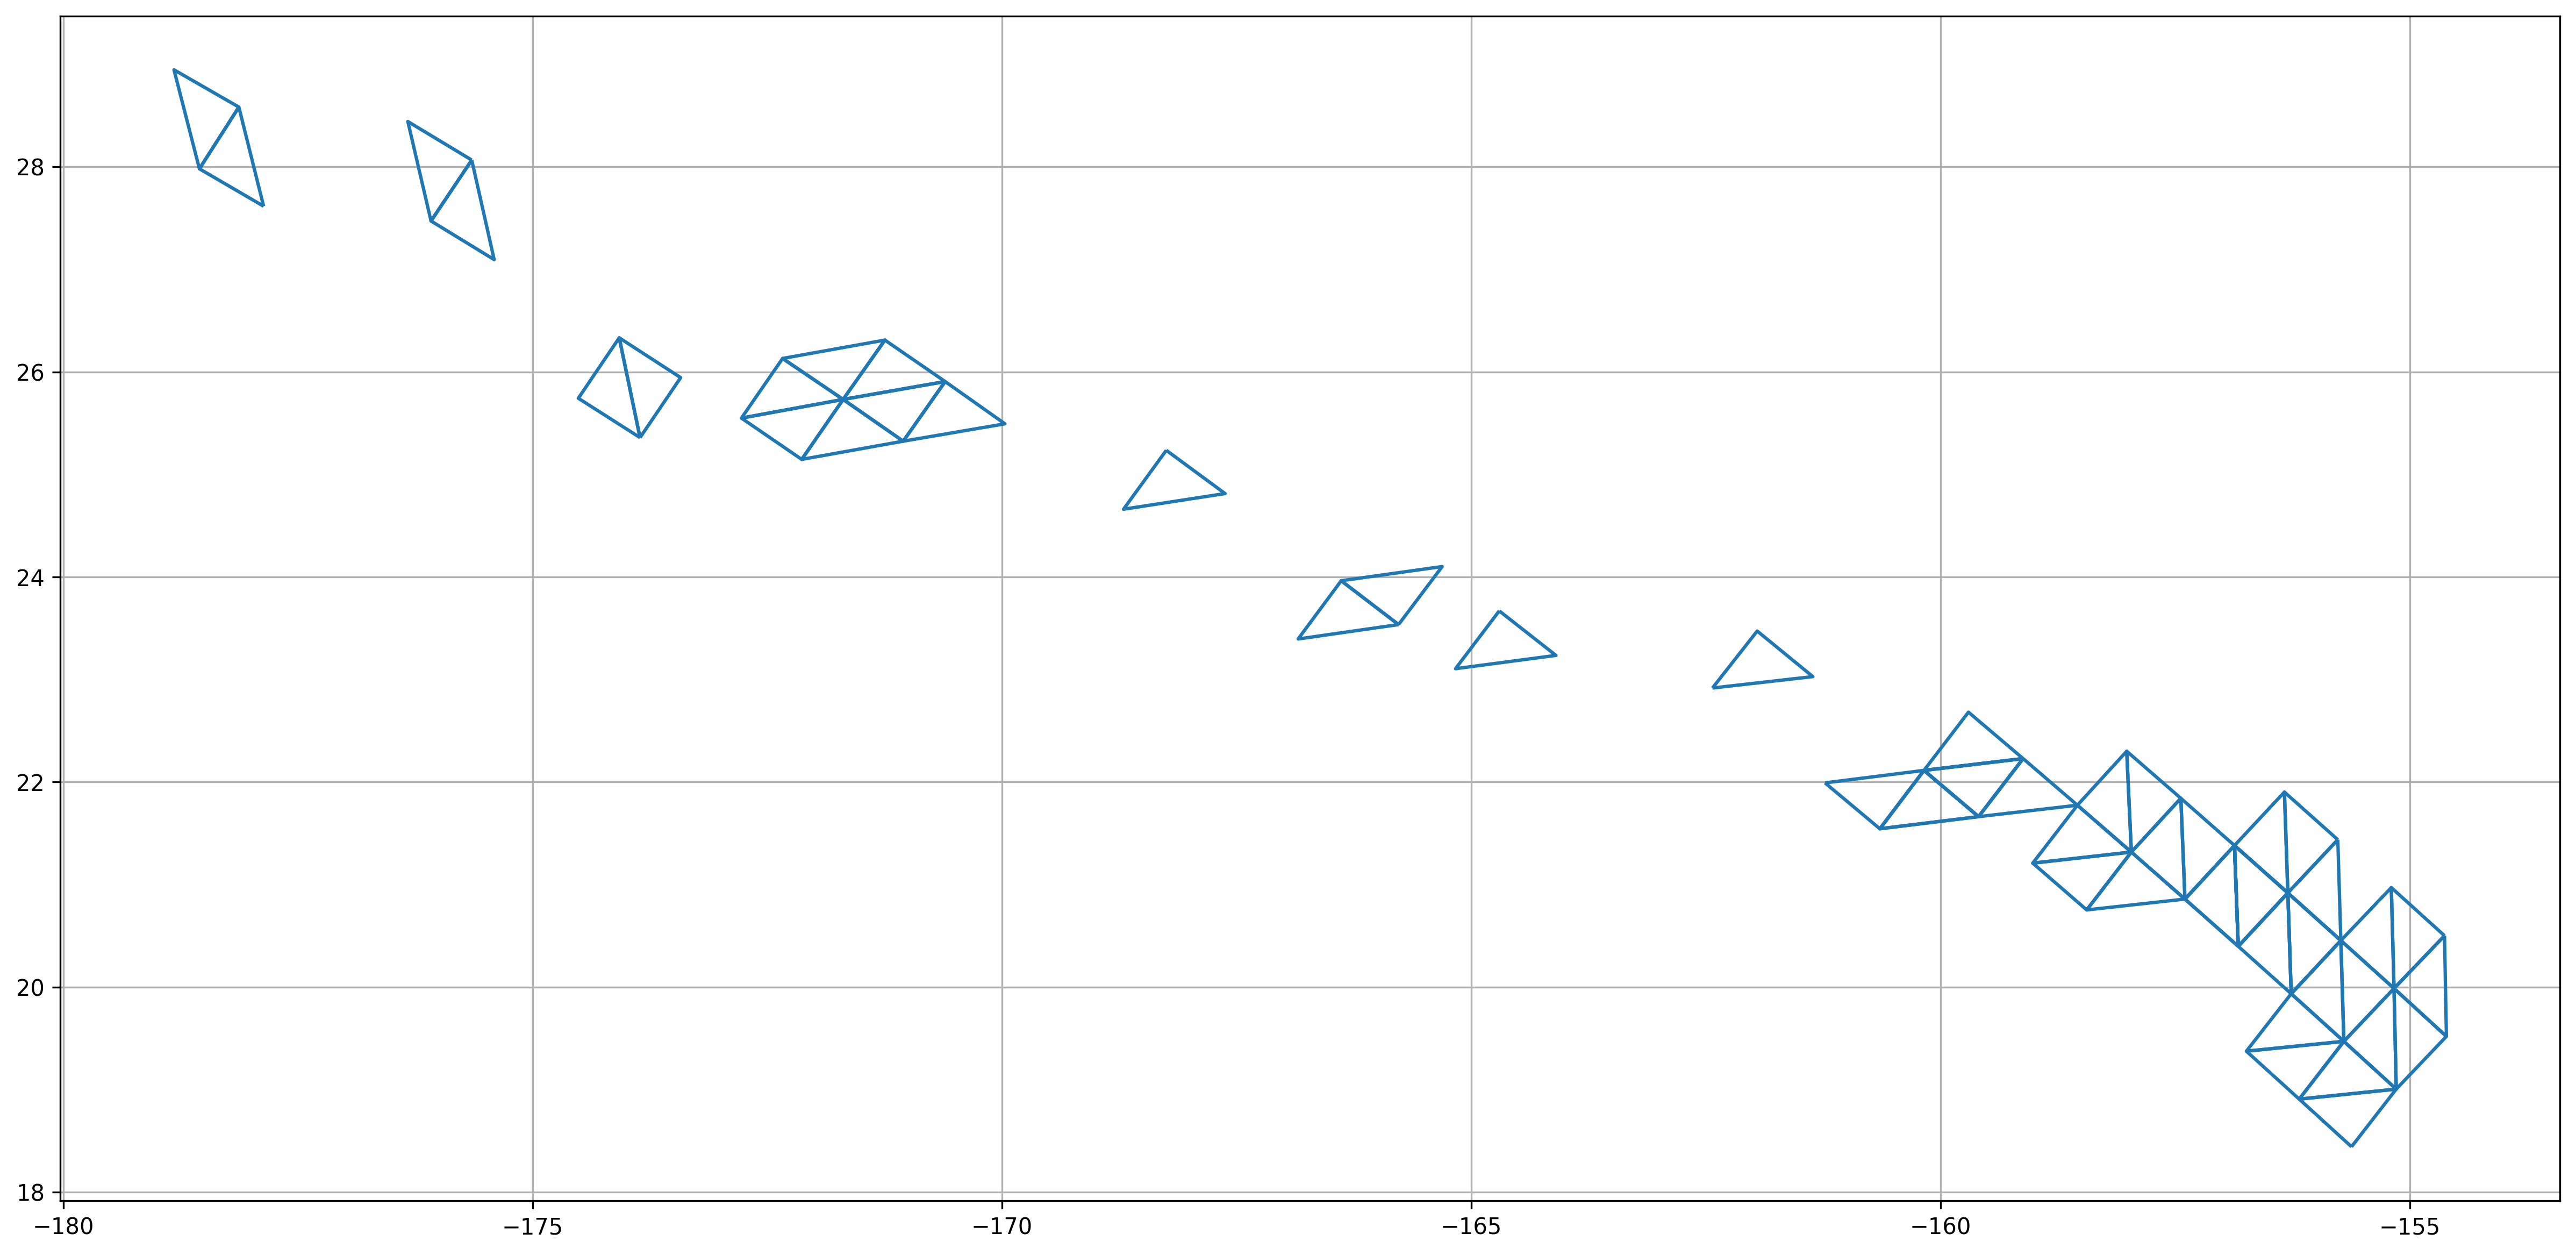

In [11]:
fig, ax = plt.subplots(figsize=(20,20), dpi=300)
ax.grid(True)

hawaii = us[us['NAME']=='Hawaii']
hawaii.plot(ax=ax, trixels=True)
hawaii

# Parallel dissolve

In [12]:
us_regions = us.stare_dissolve(by='REGION', aggfunc='sum', n_workers=10, geom=False)

In [13]:
trixels = us_regions.trixels(n_workers=4)
us_regions.set_trixels(trixels, inplace=True)

<AxesSubplot:>

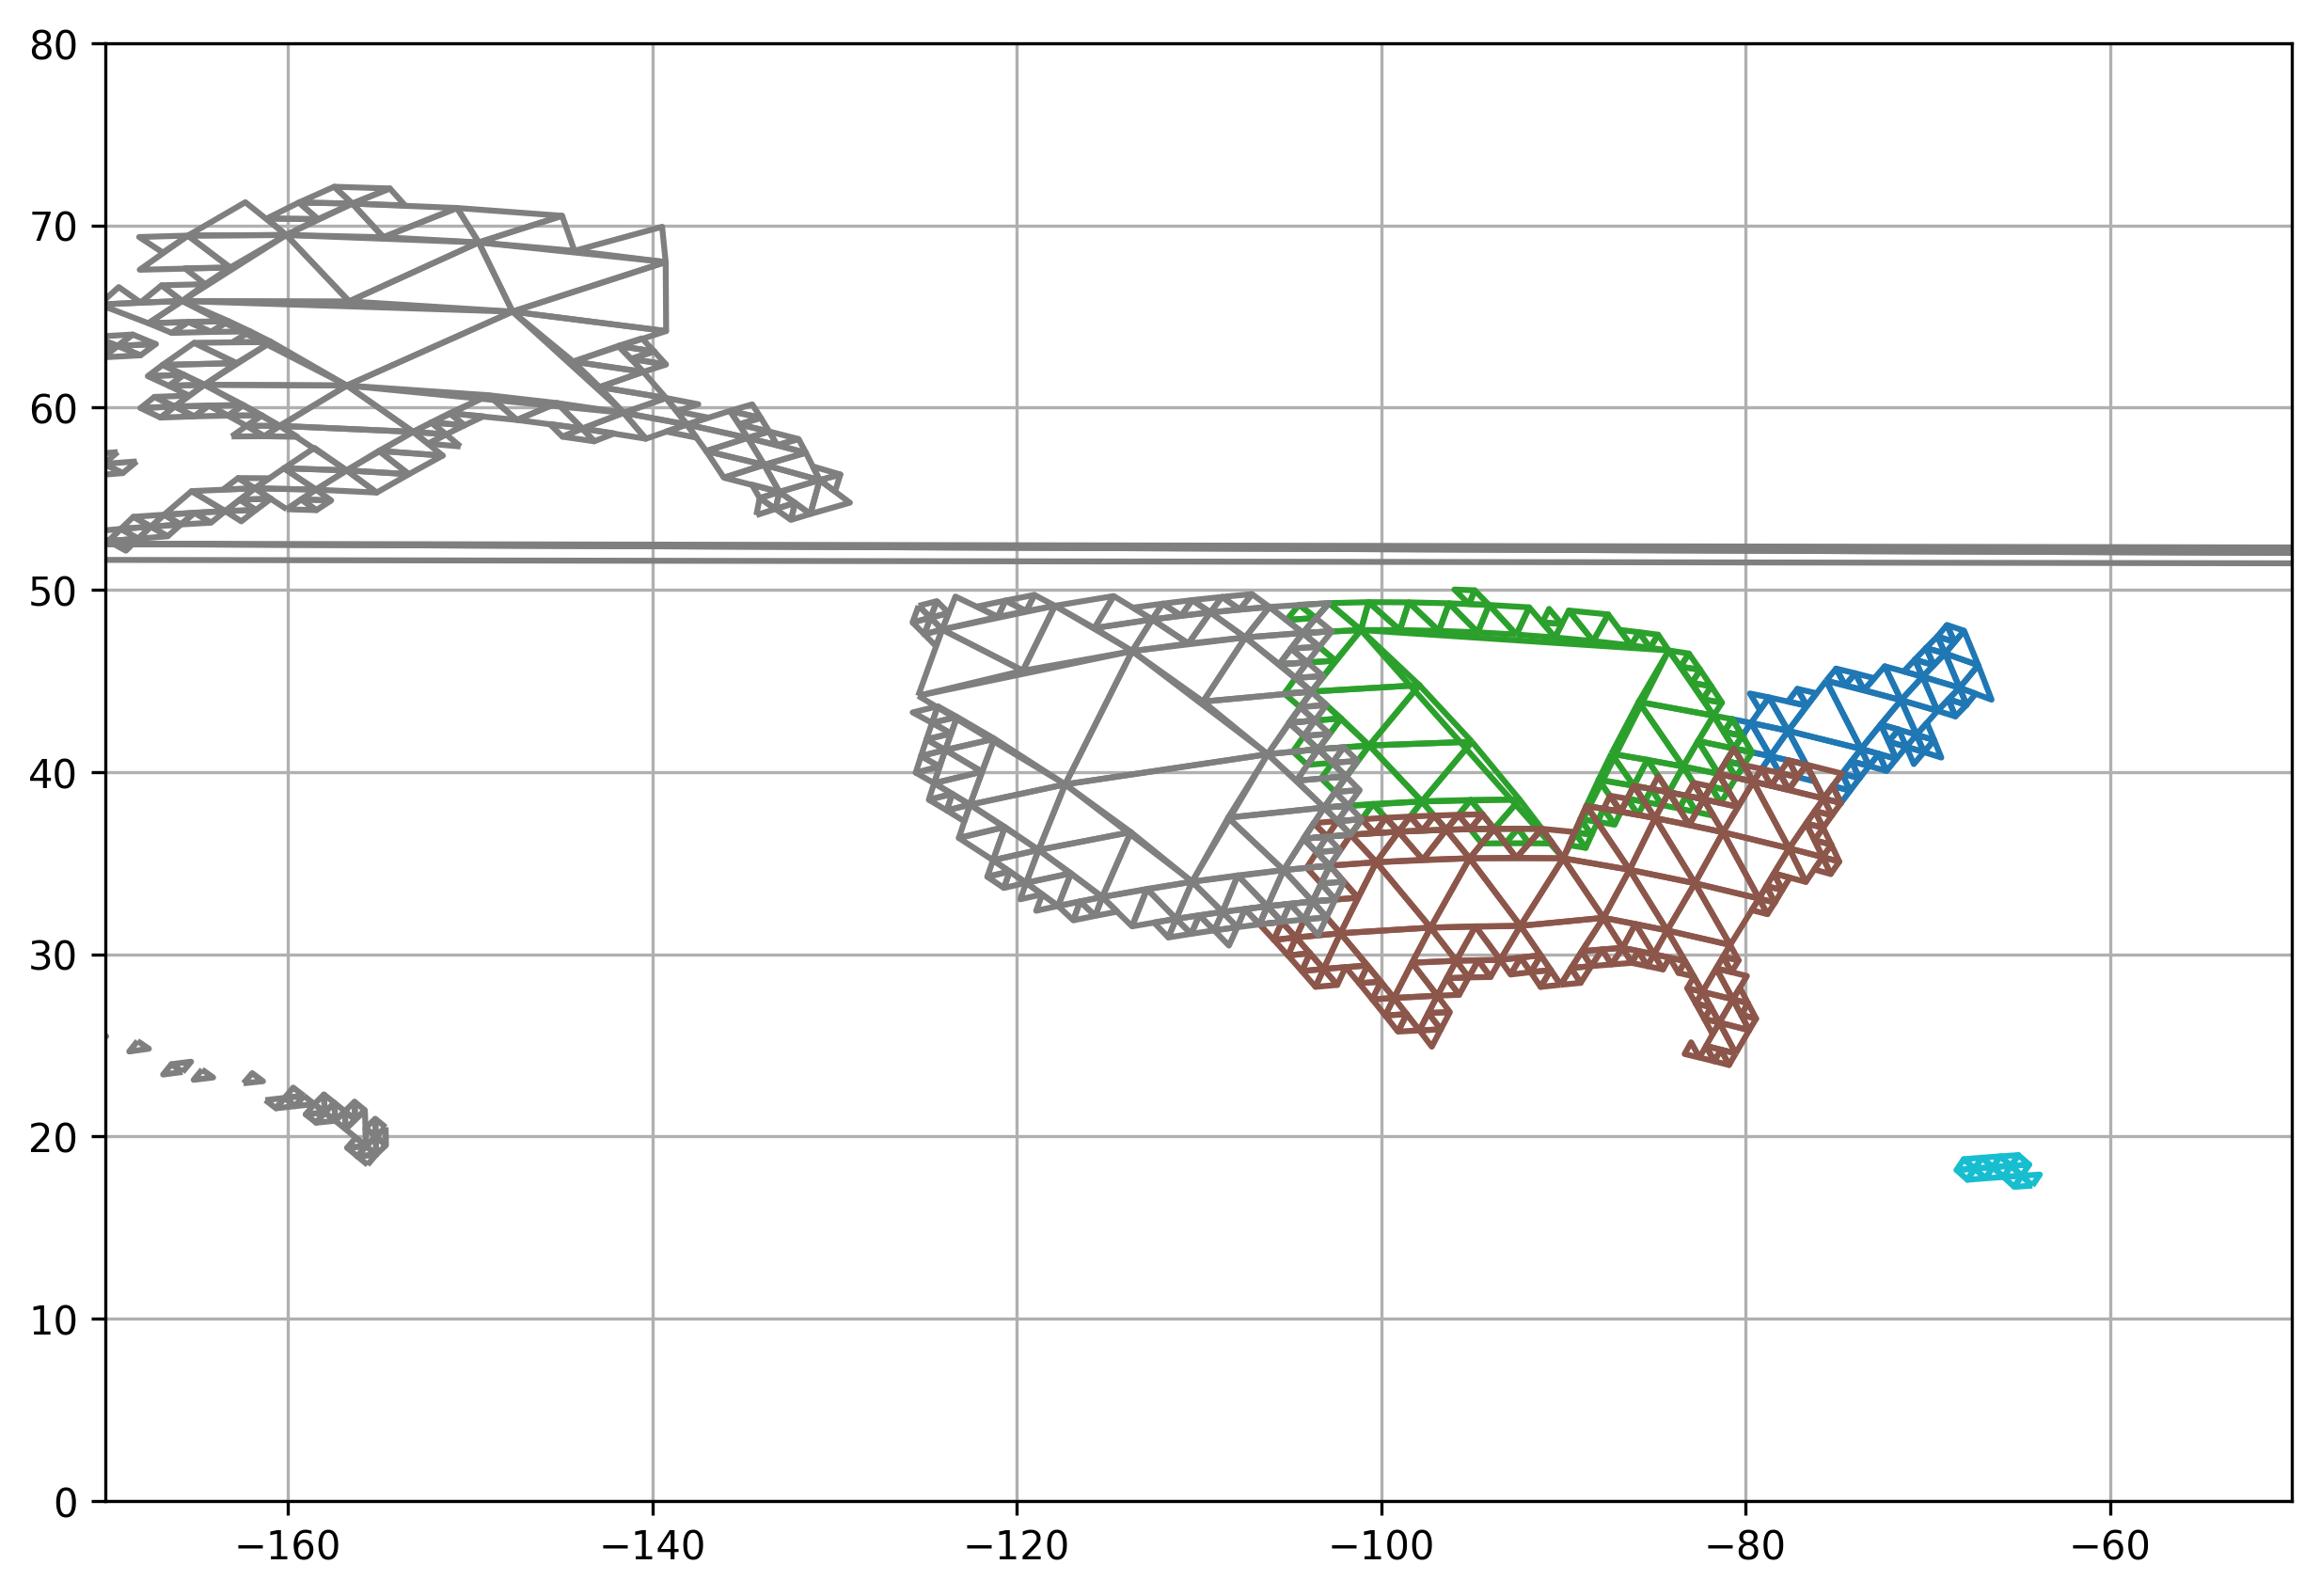

In [14]:
fig, ax = plt.subplots(figsize=(10,10), dpi=300)
ax.grid(True)

ax.set_xlim(-170, -50)
ax.set_ylim(0, 80)

us_regions.reset_index().plot(ax=ax, trixels=True, column='REGION')

# Parallel Intersects

## Cover

In [15]:
us = starepandas.STAREDataFrame(us, add_stare=True, level=8, add_trixels=True, n_workers=55)

In [18]:
filepath = '../tests/data/granules/VNP03DNB.A2020219.0742.001.2020219124651.nc'
vnp03 = starepandas.io.granules.VNP03DNB(filepath)
vnp03.read_sidecar_cover()
vnp03_cover = vnp03.stare_cover
vnp03_cover_df = starepandas.STAREDataFrame({'stare': vnp03.stare_cover}, stare='stare', add_trixels=True)

<AxesSubplot:>

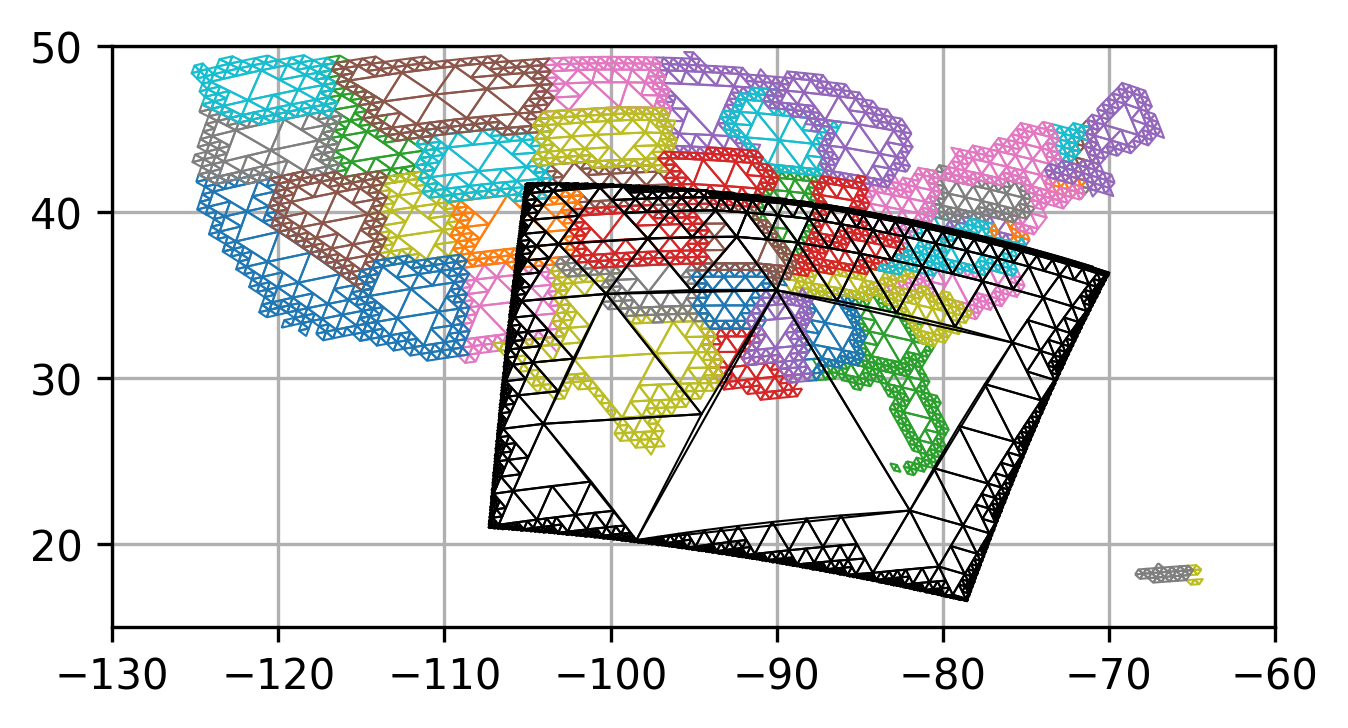

In [19]:
fig, ax = plt.subplots(figsize=(5,5), dpi=300)
ax.grid(True)

ax.set_xlim(-130, -60)
ax.set_ylim(15, 50)

us.plot(ax=ax, column='NAME', trixels=True, linewidth=0.5)
vnp03_cover_df.plot(ax=ax, trixels=True, color='k', linewidth=0.5)

In [20]:
def series_intersects(other, series, method=1, n_workers=1):
    """ 
    Returns a bool series of length len(series).
    True for every row in which row intersects other.    
    """
    
    if n_workers > len(series):
        # Cannot have more partitions than rows        
        n_workers = len(series) 
        
    if n_workers == 1:
        if series.dtype == numpy.int64:     
            # We have a series of sids; don't need to iterate. Can send the whole array to pystare/
            intersects = pystare.intersects(other, series, method)
        else:
            intersects = []   
            for sids in series:        
                if len(sids) < len(other):
                    # If we do method 1, larger item first is faster
                    intersects.append(pystare.intersects(other, sids, method).any())
                else:
                    intersects.append(pystare.intersects(sids, other, method).any())
            intersects = numpy.array(intersects)
    else:
        ddf = dask.dataframe.from_pandas(series, npartitions=n_workers)
        meta = {'intersects': 'bool'}
        res = ddf.map_partitions(lambda df: series_intersects(other, df, method, 1), meta=meta)
        intersects = res.compute(scheduler='processes')    
    return intersects

In [21]:
a = numpy.array(vnp03_cover)

In [22]:
start = datetime.datetime.now()
intersects = series_intersects(a, us['stare'] , 1, 1)
print(datetime.datetime.now() - start)

0:00:00.080116


In [23]:
start = datetime.datetime.now()
intersects = series_intersects(a, us['stare'], 1, 5)
print(datetime.datetime.now() - start)

0:00:01.652520


In [24]:
intersects

array([ True,  True,  True, False,  True, False, False, False,  True,
       False, False, False,  True, False, False, False, False,  True,
       False, False,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True, False, False,  True, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True, False,  True,  True, False, False, False,  True, False,
        True, False])

In [25]:
print(list(us[intersects]['NAME']))

['West Virginia', 'Florida', 'Illinois', 'Maryland', 'North Carolina', 'New Mexico', 'Nebraska', 'Louisiana', 'Georgia', 'Alabama', 'Ohio', 'Texas', 'Colorado', 'South Carolina', 'Oklahoma', 'Tennessee', 'Wyoming', 'Kentucky', 'Arkansas', 'Mississippi', 'Missouri', 'Kansas', 'Indiana', 'Virginia', 'Iowa']


## iFOVs

In [26]:
filepath = '../tests/data/granules/VNP03DNB.A2020219.0742.001.2020219124651.nc'
vnp03 = starepandas.read_granule(filepath, sidecar=True)

In [27]:
state_sids = us[us['NAME']=='Florida']['stare'].iloc[0]

In [28]:
start = datetime.datetime.now()
intersects = series_intersects(state_sids, vnp03['stare'])
print(datetime.datetime.now() - start)

0:00:45.298081


In [29]:
start = datetime.datetime.now()
intersects = series_intersects(state_sids, vnp03['stare'], 1, 60)
print(datetime.datetime.now() - start)

0:00:04.047494


In [30]:
intersects.sum()/vnp03.index.size

0.03200234977976144

In [31]:
vnp03[intersects]

,stare,moon_illumination_fraction,land_water_mask,quality_flag
4920413,3124172131365063694,92.879997,1,0
4920414,3124209521627100270,92.879997,1,0
4920415,3124209543803384014,92.879997,1,0
4920416,3124209539070068846,92.879997,1,0
4920417,3124209626758098798,92.879997,1,0
...,...,...,...,...
9045711,3119182659940763566,92.869995,7,0
9045712,3119182570413053838,92.869995,7,0
9045713,3119182575545090414,92.869995,7,0
9045714,3119182554226665870,92.869995,7,0


## High level

In [32]:
intersects = vnp03.stare_intersects(other=state_sids, method=1, n_workers=20)